In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
def read_csv(graph_name): 
    file_dir = "./log/v3/"
    system="gpu"
    file_name = f"{graph_name}_{system}.csv"
    file_path = os.path.join(file_dir, file_name)
    df = pd.read_csv(file_path)
    return df

def read_csv_system(graph_name, system): 
    file_dir = "."
    file_name = f"exp.csv"
    file_path = os.path.join(file_dir, file_name)
    df = pd.read_csv(file_path)
    idx = df["graph_name"] == graph_name
    df = df[idx]
    idx = df["system"] == system
    return df[idx]

def get_epoch_time(df, fanouts):
    total_epochs = df["num_epoch"][0]
    idx = df["fanouts"] == fanouts
    filtered_df = df[idx]
    y = filtered_df["duration (s)"]
    batch_size = filtered_df["batch_size"].tolist()
    y = (y / total_epochs).to_list()
    return batch_size, y

def get_avg_edges(df, fanouts):
    total_train_nodes = df["dst_nodes_l1"][0]
    idx = df["fanouts"] == fanouts
    filtered_df = df[idx]
    total_edges = filtered_df["num_edges_l3"] + filtered_df["num_edges_l2"] + filtered_df["num_edges_l1"]
    batch_size = filtered_df["batch_size"].tolist()
    y = (total_edges // total_train_nodes).to_list()
    return batch_size, y

def get_avg_dst(df, fanouts):
    total_train_nodes = df["dst_nodes_l1"][0]
    idx = df["fanouts"] == fanouts
    filtered_df = df[idx]
    num_dst = filtered_df["dst_nodes_l3"] + filtered_df["dst_nodes_l2"] + filtered_df["dst_nodes_l1"]
    batch_size = filtered_df["batch_size"].tolist()
    y = (num_dst // total_train_nodes).to_list()
    return batch_size, y

def get_avg_src(df, fanouts):
    total_train_nodes = df["dst_nodes_l1"][0]
    idx = df["fanouts"] == fanouts
    filtered_df = df[idx]
    num_src = filtered_df["src_nodes_l3"]
    batch_size = filtered_df["batch_size"].tolist()
    y = (num_src // total_train_nodes).to_list()
    return batch_size, y

def plot(graph_name, fanout, mode):
    assert(mode in ["edges", "dst", "src"])
    
    df = read_csv(graph_name)
    batch_size = None
    y = None
    y_label = None
    if mode == "edges":
        batch_size, y = get_avg_edges(df, fanout)
        y_label = "Average # Edges"
    elif mode == "dst":
        batch_size, y = get_avg_dst(df, fanout)
        y_label = "Average # DstNodes"
    elif mode == "src":
        batch_size, y = get_avg_src(df, fanout)
        y_label = "Average # SrcNodes"
        
    title_font = {#'family': 'serif',
        'weight': 'normal',
        'size': 18,
        }
    
    label_font = {#'family': 'serif',
        'weight': 'normal',
        'size': 18,
        }
    
    axis_font = {#'family': 'serif',
        'weight': 'normal',
        'size': 13,
        }
    
    fig, ax = plt.subplots(figsize=(6,4))
    plt.rc('ytick', labelsize=14) 
    ax.scatter(x=batch_size, y=y)
    ax.set_xscale('log', base=2)
    ax.set_xlabel("Batch Size", fontdict=label_font)
    ax.set_ylabel(y_label, fontdict=label_font)
    ax.set_title(f"{graph_name} | fanouts: {fanout}", fontdict=title_font)
    ax.set_xticks(ticks=batch_size, labels=batch_size, fontdict=axis_font)
    plt.tight_layout()
    
    file_name = f"{graph_name}_{mode}_{fanout}.png"
    plt.savefig(f"./figs/{file_name}")
    
def plot_time(graph_name, fanout):    
    df_dgl = read_csv_system(graph_name, "dgl")
    df_base = read_csv_system(graph_name, "base")
    # df_gpu = read_csv_system(graph_name, "gpu")
    batch_size, y_dgl = get_epoch_time(df_dgl, fanout)
    batch_size, y_base = get_epoch_time(df_base, fanout)
    # batch_size, y_gpu = get_epoch_time(df_gpu, fanout)
    y_label = "Sampling / Epoch (s)"
    title_font = {#'family': 'serif',
        'weight': 'normal',
        'size': 18,
        }
    
    label_font = {#'family': 'serif',
        'weight': 'normal',
        'size': 18,
        }
    
    axis_font = {#'family': 'serif',
        'weight': 'normal',
        'size': 13,
        }
    
    fig, ax = plt.subplots(figsize=(6,4))
    # plt.rc('ytick', labelsize=14) 
    ax.scatter(x=batch_size, y=y_dgl, label="Dgl")
    ax.scatter(x=batch_size, y=y_base, label="Base")
    ax.set_xscale('log', base=2)
    ax.set_xlabel("Batch Size", fontdict=label_font)
    ax.set_ylabel(y_label, fontdict=label_font)
    ax.set_title(f"{graph_name} | fanouts: {fanout}", fontdict=title_font)
    ax.set_xticks(ticks=batch_size, labels=batch_size, fontdict=axis_font)
    plt.legend(prop = { "size": 16 })
    plt.tight_layout()
    
    file_name = f"{graph_name}_{fanout}_time.png"
    plt.savefig(f"./figs/{file_name}")

    
def plot_batch(graph_name, fanout, batch_size):
    def get_batch_epoch_time(df, fanouts, batch_size):
        idx = df["fanouts"] == fanouts 
        df = df[idx]
        idx = df["batch_size"] == batch_size
        df = df[idx]
        y = df["epoch (s)"]
        y = y.to_list()
        x = df["pool_size"]
        x = x.to_list()
        return x, y
    
    df_batch = read_csv_system(graph_name, "batch")
    df_base_uva = read_csv_system(graph_name, "base-uva")
    df_base_gpu = read_csv_system(graph_name, "base-gpu")
    df_dgl = read_csv_system(graph_name, "dgl-uva")
    # print(f"{df_batch=}\n{df_base=}\n{df_dgl=}\n")

    x, y_batch = get_batch_epoch_time(df_batch, fanout, batch_size)
    _, y_base = get_batch_epoch_time(df_base_uva, fanout, batch_size)
    _, y_gpu = get_batch_epoch_time(df_base_gpu, fanout, batch_size)
    _, y_dgl = get_batch_epoch_time(df_dgl, fanout, batch_size)
    
    # print(f"{y_batch=}\n{y_base=}\n{y_dgl=}\n")
    y_label = "Sample Time (s)"
    title_font = {#'family': 'serif',
        'weight': 'normal',
        'size': 18,
        }
    
    label_font = {#'family': 'serif',
        'weight': 'normal',
        'size': 18,
        }
    
    axis_font = {#'family': 'serif',
        'weight': 'normal',
        'size': 13,
        }
    
    fig, ax = plt.subplots(figsize=(6,4))
    plt.rc('ytick', labelsize=14) 
    ax.axhline(y=y_dgl, label="DGL-UVA", color="blue")
    ax.axhline(y=y_base, label="Base-UVA", color="red")
    ax.axhline(y=y_gpu, label="Base-GPU", color="black")
    ax.scatter(x=x, y=y_batch, label="Batch")
    ax.set_xscale('log', base=2)
    ax.set_xlabel("Pool Sizes", fontdict=label_font)
    ax.set_ylabel(y_label, fontdict=label_font)
    ax.set_title(f"{graph_name} | {fanout} | {batch_size}", fontdict=title_font)
    ax.set_xticks(ticks=x, labels=x, fontdict=axis_font)
    plt.ylim(bottom=0)
    plt.legend(prop = { "size": 16 })
    plt.tight_layout()
    
    file_name = f"{graph_name}_{fanout}_{batch_size}.png"
    plt.savefig(f"./figs/{file_name}")
    
def plot_mem(graph_name, fanout, batch_size):
    def get_batch_epoch_time(df, fanouts, batch_size):
        idx = df["fanouts"] == fanouts 
        df = df[idx]
        idx = df["batch_size"] == batch_size
        df = df[idx]
        y = df["reserved (MB)"]
        y = y.to_list()
        x = df["pool_size"]
        x = x.to_list()
        return x, y
    
    df_batch = read_csv_system(graph_name, "batch")
    df_base_uva = read_csv_system(graph_name, "base-uva")
    df_base_gpu = read_csv_system(graph_name, "base-gpu")
    df_dgl = read_csv_system(graph_name, "dgl-uva")
    # print(f"{df_batch=}\n{df_base=}\n{df_dgl=}\n")

    x, y_batch = get_batch_epoch_time(df_batch, fanout, batch_size)
    _, y_base = get_batch_epoch_time(df_base_uva, fanout, batch_size)
    _, y_gpu = get_batch_epoch_time(df_base_gpu, fanout, batch_size)
    _, y_dgl = get_batch_epoch_time(df_dgl, fanout, batch_size)
    
    # print(f"{y_batch=}\n{y_base=}\n{y_dgl=}\n")
    y_label = "GPU Memory (MB)"
    title_font = {#'family': 'serif',
        'weight': 'normal',
        'size': 18,
        }
    
    label_font = {#'family': 'serif',
        'weight': 'normal',
        'size': 18,
        }
    
    axis_font = {#'family': 'serif',
        'weight': 'normal',
        'size': 13,
        }
    
    fig, ax = plt.subplots(figsize=(6,4))
    plt.rc('ytick', labelsize=14) 
    ax.axhline(y=y_dgl, label="DGL-UVA", color="blue")
    ax.axhline(y=y_base, label="Base-UVA", color="red")
    ax.axhline(y=y_gpu, label="Base-GPU", color="black")
    ax.scatter(x=x, y=y_batch, label="Batch")
    ax.set_xscale('log', base=2)
    ax.set_xlabel("Pool Sizes", fontdict=label_font)
    ax.set_ylabel(y_label, fontdict=label_font)
    ax.set_title(f"{graph_name} | {fanout} | {batch_size}", fontdict=title_font)
    ax.set_xticks(ticks=x, labels=x, fontdict=axis_font)
    plt.ylim(bottom=0)
    plt.legend(prop = { "size": 16 })
    plt.tight_layout()
    
    file_name = f"{graph_name}_{fanout}_{batch_size}_mem.png"
    plt.savefig(f"./figs/{file_name}")

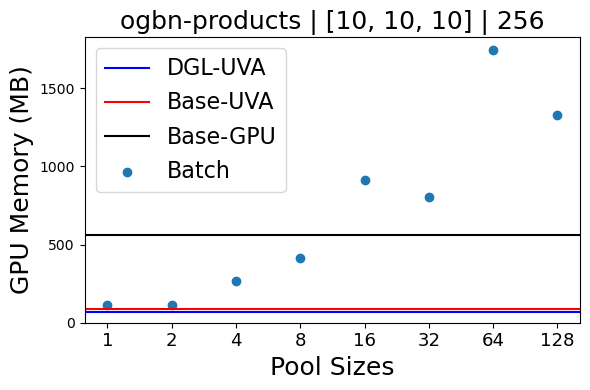

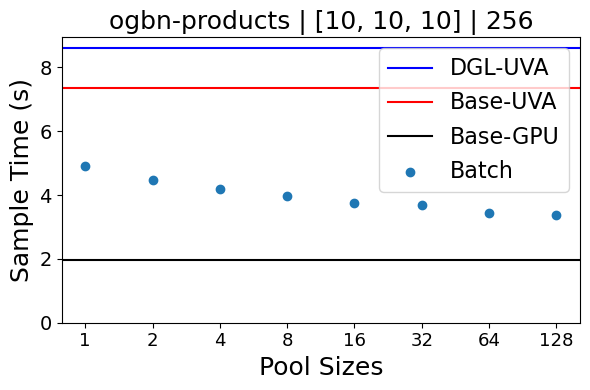

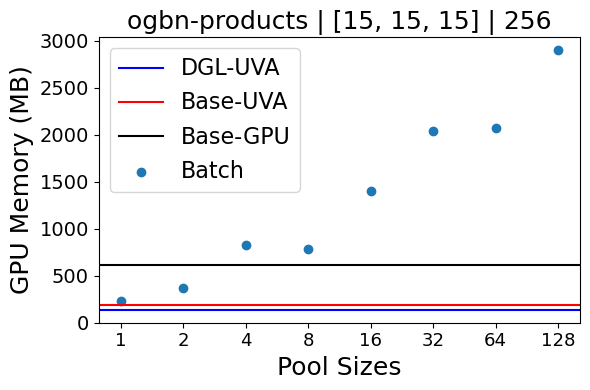

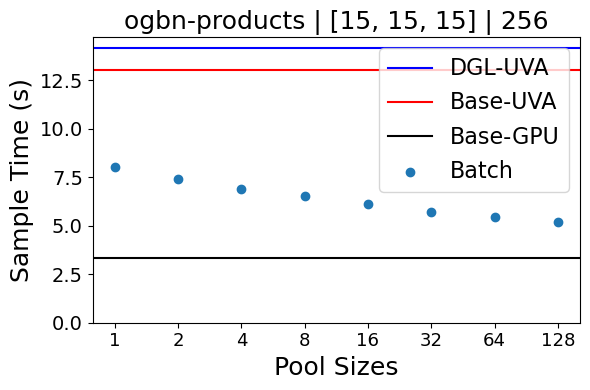

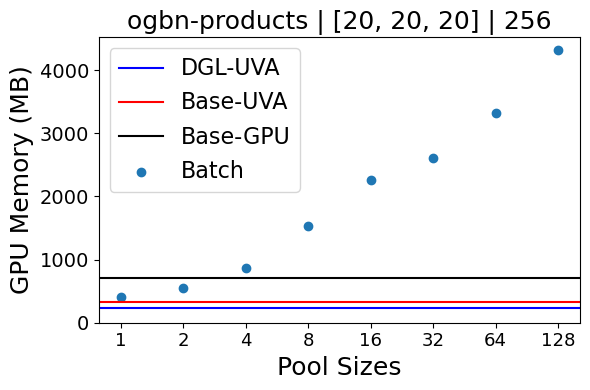

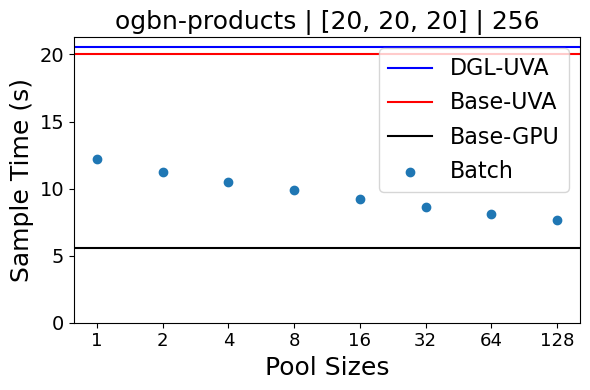

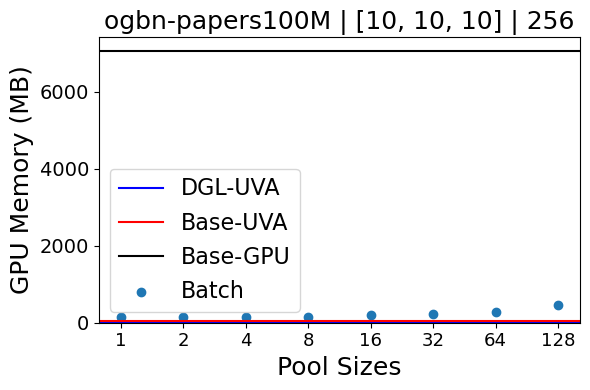

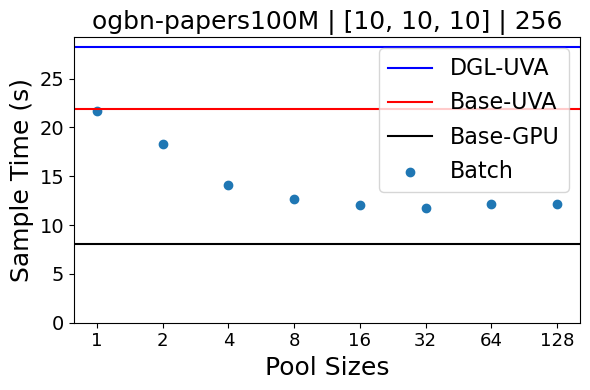

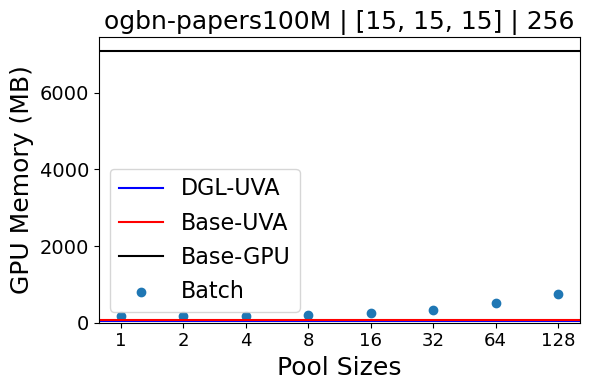

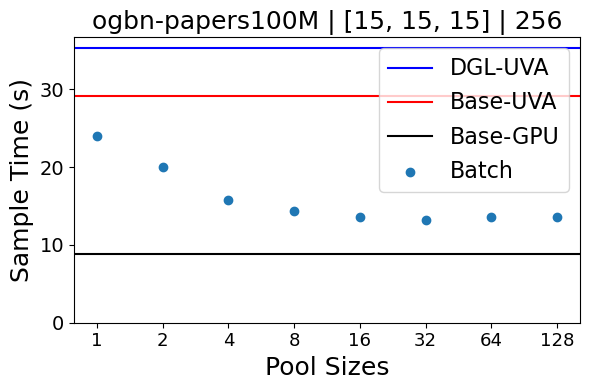

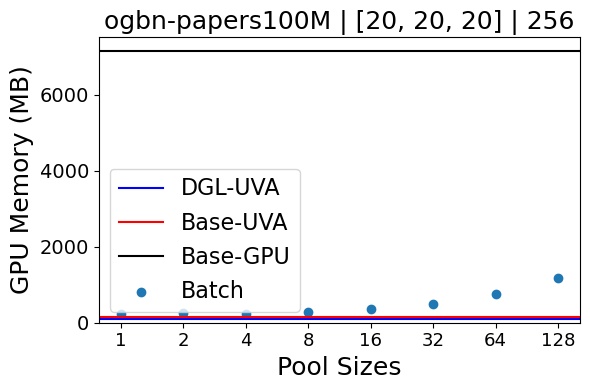

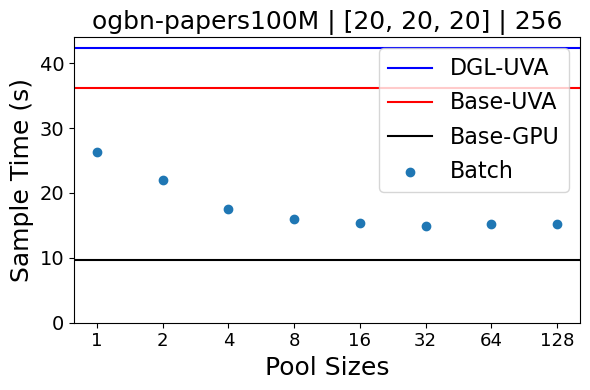

In [2]:
for graph_name in ["ogbn-products", "ogbn-papers100M"]:
    for fanout in ["[10, 10, 10]", "[15, 15, 15]", "[20, 20, 20]"]:
        plot_mem(graph_name=graph_name, fanout=fanout, batch_size=256)
        plot_batch(graph_name=graph_name, fanout=fanout, batch_size=256)